In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML

In [2]:
import operator

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from lib.unpack import unpack_drawings
from lib.strokes import transform_strokes, inverse_transform_strokes, get_n_points
from lib.dataset import get_dataset, get_train_val_idxs, get_batches
from lib.dataset import get_stds, standarize_data, unstandarize_flat_strokes
from lib.plot import get_canvas, plot, get_animation
from lib.model import Decoder
from lib.model import train, evaluate, reconstruction_loss
from lib.model import generate

# Load and show dataset

In [4]:
dataset_name = 'firetruck'

In [5]:
dataset = unpack_drawings(f'./data/{dataset_name}.bin')
dataset = list(dataset)

In [6]:
good_drawings, bad_drawings = [], []
for item in dataset:
    if item['recognized']:
        good_drawings.append(item['image'])
    else:
        bad_drawings.append(item['image'])

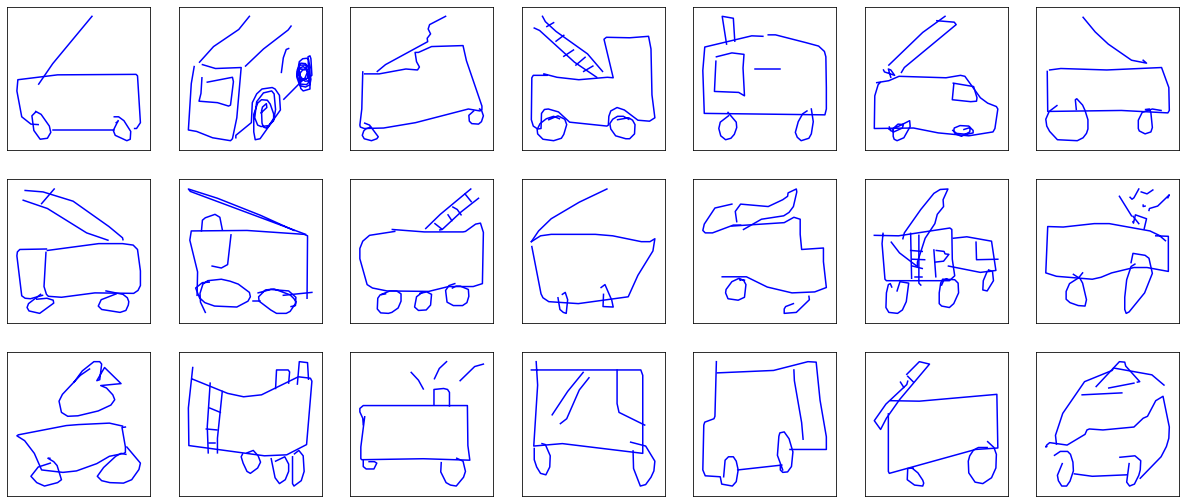

In [7]:
fig, axarr = get_canvas(3, 7)

for i, ax in enumerate(axarr.flatten()):
    plot(good_drawings[i], color='b', ax=ax)

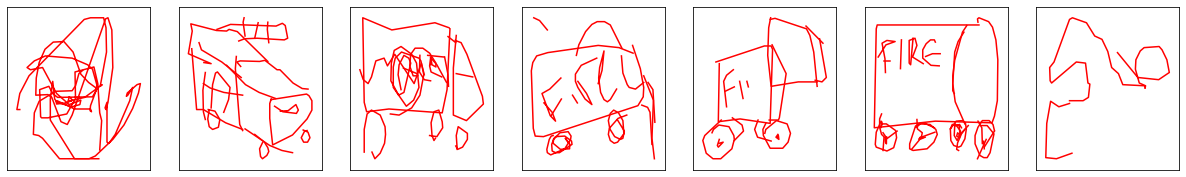

In [8]:
fig, axarr = get_canvas(1, 7)

for i, ax in enumerate(axarr.flatten()):
    plot(bad_drawings[i], color='r', ax=ax)

In [9]:
%%capture
idx = np.random.choice(range(len(good_drawings)))
anim = get_animation(good_drawings[idx])

In [10]:
HTML(anim.to_html5_video())

Text(0.5, 1.0, 'delta_y')

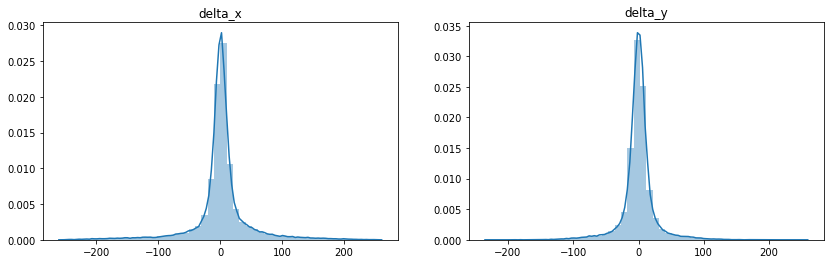

In [11]:
# Transformed stroke coordinates follow a gaussian distribution.

transformed_drawings = [transform_strokes(good_drawings[i]) for i in range(1000)]

delta_xs, delta_ys = [], []
for transformed_drawing in transformed_drawings:
    delta_xs += list(map(operator.itemgetter(0), transformed_drawing))
    delta_ys += list(map(operator.itemgetter(1), transformed_drawing))

_, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(delta_xs, ax=axs[0]).set_title('delta_x')
sns.distplot(delta_ys, ax=axs[1]).set_title('delta_y')

# Create pytorch dataset

In [12]:
np.percentile([get_n_points(drawing) for drawing in good_drawings], [5, 10, 25, 50, 75, 90, 95])

array([32., 36., 44., 54., 66., 81., 91.])

In [13]:
min_drawings_len = np.percentile([get_n_points(drawing) for drawing in good_drawings], 10)
max_drawings_len = np.percentile([get_n_points(drawing) for drawing in good_drawings], 90)
min_drawings_len, max_drawings_len

(36.0, 81.0)

In [14]:
drawings = [drawing for drawing in good_drawings if min_drawings_len <= get_n_points(drawing) <= max_drawings_len]
transformed_drawings = [transform_strokes(drawing) for drawing in drawings]

In [15]:
#idxs = list(range(1))
#transformed_drawings = [transformed_drawings[i] for i in idxs]

In [16]:
ds = get_dataset(transformed_drawings)

In [17]:
train_idxs, val_idxs = get_train_val_idxs(len(ds), sample_ratio=0.92)
#train_idxs, val_idxs = [idxs, idxs]

train_ds = Subset(ds, train_idxs)
val_ds = Subset(ds, val_idxs)

len(train_ds), len(val_ds)

(111837, 37239)

In [18]:
train_stds = get_stds(train_ds)
val_stds = get_stds(val_ds)

In [19]:
# Debug batches generation

train_batches = get_batches(train_ds, train_stds, batch_size=1)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

print(data_batch.shape, labels_batch.shape, lengths_batch.shape)
print()

for tensor in (data_batch, labels_batch, lengths_batch):
    print()
    print('-------------')
    print()
    print(tensor[:5])
    print(tensor[-5:])

torch.Size([81, 1, 5]) torch.Size([81, 1, 5]) torch.Size([1])


-------------

tensor([[[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000]],

        [[ 0.4881, -0.2788,  1.0000,  0.0000,  0.0000]],

        [[ 0.5103, -0.0398,  1.0000,  0.0000,  0.0000]],

        [[ 0.5991,  0.1593,  1.0000,  0.0000,  0.0000]],

        [[ 0.6878,  0.0000,  1.0000,  0.0000,  0.0000]]])
tensor([[[-0.0444,  1.5929,  1.0000,  0.0000,  0.0000]],

        [[-0.3994, -0.2389,  1.0000,  0.0000,  0.0000]],

        [[-0.6657, -0.0398,  1.0000,  0.0000,  0.0000]],

        [[ 0.3106, -0.5177,  1.0000,  0.0000,  0.0000]],

        [[ 0.1331, -0.9557,  0.0000,  0.0000,  1.0000]]])

-------------

tensor([[[ 0.4881, -0.2788,  1.0000,  0.0000,  0.0000]],

        [[ 0.5103, -0.0398,  1.0000,  0.0000,  0.0000]],

        [[ 0.5991,  0.1593,  1.0000,  0.0000,  0.0000]],

        [[ 0.6878,  0.0000,  1.0000,  0.0000,  0.0000]],

        [[ 1.6198,  0.2788,  1.0000,  0.0000,  0.0000]]])
tensor([[[-0.3994, -0.2389,  1.0000

In [20]:
# Debug model forward

model = Decoder(dim_input=5, dim_hidden=5, n_gaussians=6)

if torch.cuda.is_available():
    model = model.cuda()

train_batches = get_batches(train_ds, train_stds, batch_size=3)
data_batch, labels_batch, lengths_batch = next(iter(train_batches))

gmm_params, strokes_state_params, lstm_states = model(data_batch, lengths_batch)

In [21]:
pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = gmm_params
hidden_state, cell_state = lstm_states

print(pi.shape)
print(mu_x.shape, mu_y.shape)
print(sigma_x.shape, sigma_y.shape, rho_xy.shape)

print(strokes_state_params.shape)

print(hidden_state.shape, cell_state.shape)

torch.Size([81, 3, 6])
torch.Size([81, 3, 6]) torch.Size([81, 3, 6])
torch.Size([81, 3, 6]) torch.Size([81, 3, 6]) torch.Size([81, 3, 6])
torch.Size([81, 3, 3])
torch.Size([1, 3, 5]) torch.Size([1, 3, 5])


In [22]:
# Debug loss
reconstruction_loss(gmm_params, strokes_state_params, labels_batch, lengths_batch)

tensor(3.8921, grad_fn=<AddBackward0>)

In [23]:
# Debug generation
generate(model, n_points=3)

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.1494, -0.3000,  1.0000,  0.0000,  0.0000],
        [ 1.4889, -2.6946,  1.0000,  0.0000,  0.0000],
        [ 0.8051, -1.5992,  0.0000,  1.0000,  0.0000]])

# Train

In [74]:
batch_size = 64
dim_hidden = 512
n_gaussians = 20

model = Decoder(5, dim_hidden, n_gaussians)
if torch.cuda.is_available():
    model = model.cuda()

model_name = f'gmm{dim_hidden}_{n_gaussians}'

criterion = reconstruction_loss
optimizer = Adam(model.parameters(), 1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

In [75]:
print(model)

Decoder(
  (lstm): LSTM(5, 512)
  (output_weights): Linear(in_features=512, out_features=123, bias=True)
)


In [77]:
train(model, scheduler, criterion, train_ds, val_ds, train_stds, val_stds, batch_size,
      epochs=300, epochs_between_evals=10)

epoch:   1   train_loss: 1.33515   val_loss: 1.48976
epoch:   4   train_loss: 0.90702   val_loss: 1.11907


In [80]:
model_path = f'models/unconditional/{model_name}_{dataset_name}.pth'
print(model_path)
torch.save(model.state_dict(), f'models/unconditional/{model_name}_{dataset_name}.pth')

models/gmm_20_firetruck.pth


# Predict

In [25]:
dim_hidden = 512
n_gaussians = 20

model_name = f'gmm{dim_hidden}_{n_gaussians}'
model_path = f'models/unconditional/{model_name}_{dataset_name}.pth'
print(model_path)

model = Decoder(5, dim_hidden, n_gaussians)
if torch.cuda.is_available():
    model = model.cuda()

map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load(model_path, map_location=map_location))

models/unconditional/gmm512_20_firetruck.pth


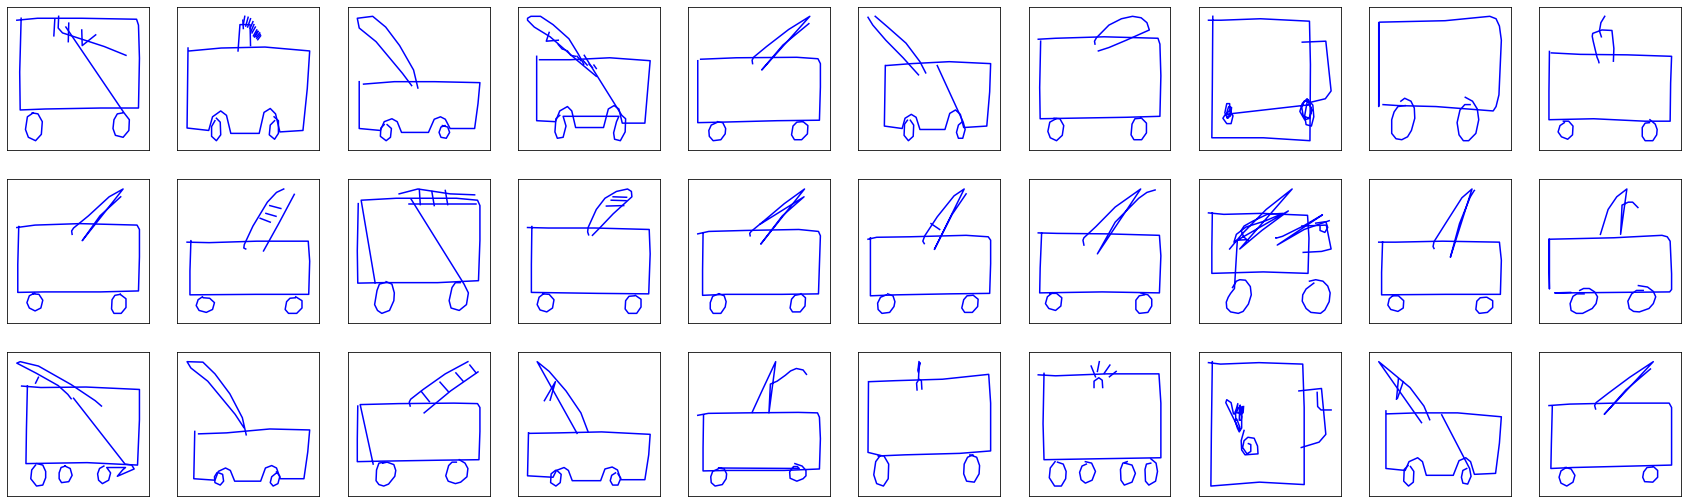

In [32]:
temperature_gmm = 0.01
temperature_state = 0.1
temperature_eos = 1.1

fig, axarr = get_canvas(3, 10)

all_preds_strokes = []
for i, ax in enumerate(axarr.flatten()):
    pred_flat_strokes = generate(model, n_points=150, temperature_gmm=temperature_gmm,
                                 temperature_state=temperature_state, temperature_eos=temperature_eos)
    pred_flat_strokes = unstandarize_flat_strokes(pred_flat_strokes, val_stds)
    pred_strokes = inverse_transform_strokes(pred_flat_strokes)
    all_preds_strokes.append(pred_strokes)
    plot(pred_strokes, color='b', ax=ax)

In [33]:
%%capture
pred_anim = get_animation(all_preds_strokes[0])

In [34]:
# Generated drawing
HTML(pred_anim.to_html5_video())

In [35]:
#pred_anim.save('generated.gif', dpi=80, writer='imagemagick')